## Chapter 3. 분류

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
# 이미지가 28 * 28 픽셀이기 때문에, 784개의 특성을 갖고 있음
print(y.shape)

(70000, 784)
(70000,)


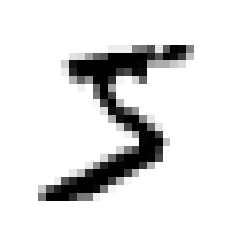

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

some_digit = X.loc[0]
some_digit_image = np.array(some_digit).reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
# 레이블은 문자열이기 때문에, 정수로 변환
print(y[0])
y = y.astype(np.uint8)

5


In [5]:
# MNIST 데이터셋은 이미 훈련 세트와 테스트 세트로 나뉘어져 있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Binary Classifier Training

In [6]:
# 분류를 위한 타깃 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=2022)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=2022)

In [8]:
sgd_clf.predict([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

## 3.3 Measure Performance

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2022, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9481
0.949
0.9511


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96525, 0.94745, 0.9576 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    # 예측 시, 무조건 5 아님으로 예측 (False로 예측)
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53579,  1000],
       [ 1594,  3827]], dtype=int64)

In [15]:
y_train_prefect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [16]:
# precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7928319867412471

In [17]:
recall_score(y_train_5, y_train_pred)

0.705958310274857

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7468774395003902

In [19]:
# Trade-off of precision / recall
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-15068.16963826, -29651.60358376, -11847.23169549,
         -3374.65732295, -19516.78280274,   2672.70747991,
        -20334.05018793, -21949.32945898, -13106.00462301,
        -12815.14997077]])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([[False, False, False, False, False, False, False, False, False,
        False]])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  5123.10591183, -29796.08959255, -40769.42804345, ...,
         4835.20014047,  -7413.32455359, -11525.86105574])

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family
plt.rc('axes', unicode_minus=False)

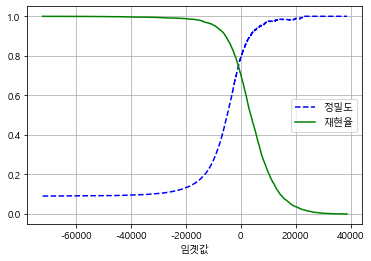

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label='재현율')
    plt.legend()
    plt.xlabel('임곗값')
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()   

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.51300498063088


In [30]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

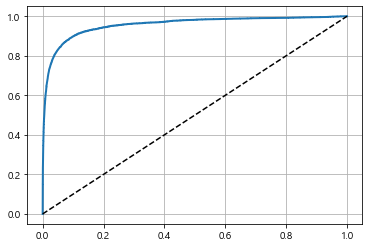

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9563861842380696

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=2022)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [37]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

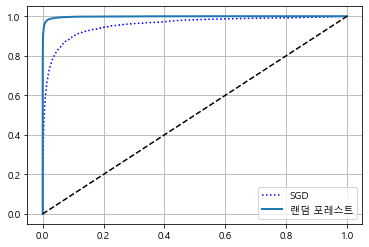

In [38]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='lower right')
plt.show()

### 3.4 Multicalss Classifier

In [41]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print('some digit:', some_digit)
svm_clf.predict([some_digit])

some digit: pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64


c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5]

5

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]


c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  w

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-15068.16963826, -29651.60358376, -11847.23169549,
         -3374.65732295, -19516.78280274,   2672.70747991,
        -20334.05018793, -21949.32945898, -13106.00462301,
        -12815.14997077]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8843 , 0.885  , 0.87685])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9005 , 0.8943 , 0.89975])

### 3.5 Error Analysis

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5571,    0,   21,    6,    9,   48,   35,    6,  226,    1],
       [   0, 6399,   37,   25,    4,   45,    4,    8,  207,   13],
       [  27,   26, 5232,   95,   72,   26,   67,   35,  370,    8],
       [  23,   17,  117, 5239,    2,  212,   27,   38,  385,   71],
       [  12,   14,   48,    9, 5194,   12,   35,   25,  326,  167],
       [  27,   15,   30,  166,   53, 4454,   77,   15,  521,   63],
       [  30,   15,   41,    3,   41,   97, 5561,    3,  126,    1],
       [  20,    9,   52,   32,   50,   13,    3, 5692,  181,  213],
       [  17,   63,   46,   94,    3,  129,   24,   10, 5423,   42],
       [  24,   18,   31,   69,  117,   35,    1,  174,  354, 5126]],
      dtype=int64)

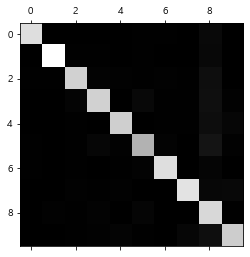

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

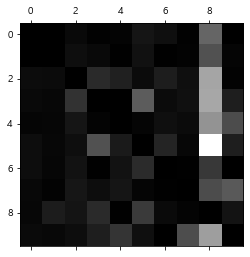

In [55]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

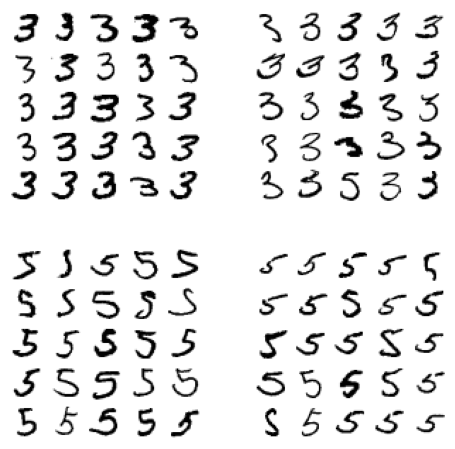

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### 3.6 Multi label Classification

In [59]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [60]:
knn_clf.predict([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### 3.7 Multioutput-multiclass classification

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [84]:
def plot_digit(data):
    image = np.array(data).reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

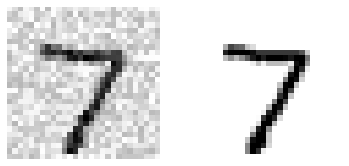

In [85]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index])
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index])
plt.show()

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


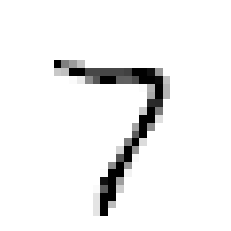

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)